## Internship Application for CLIMDES internship Prediction with Machine Learning

**Table of contents**
- Data Simulation
- Data Cleaning and preprocessing
- Cross validation
- Model Buidling, training and evaluation
- Hyperparameter optimization
- Model deployment
- Model Explanability


Data Simulation

The dataset  will be simulated using LLM(chatgpt)
2000 samples will be generated with about 15 features where 50% will be randomly generated and the 50% will be generated conditionaly using a formualted success algorithm

In [ ]:
!pip install xgboost catboost lgm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.8 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
import catboost
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
import lightgbm as lgm
import optuna
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\User\Desktop\Blessing_AI\Joy-Project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Seed for reproducibility
np.random.seed(0)

# Define a helper function to determine success based on a set of weighted conditions
def determine_success(row):
    score = (row['Language_Proficiency'] in ['Advanced', 'Native']) * 2 + \
            (row['Work_Experience'] >= 2) + \
            (row['Internet_Availability'] == 'High-Speed') * 2 + \
            (row['Soft_Skills'] in ['Good', 'Excellent']) * 2 + \
            (row['Hours_Dedicated'] >= 15)
    # Assuming that a score of 3 or more leans towards success
    return 1 if score >= 3 else 0

# Configuration of possible values for the dataset features
config = {
    'age_range': (18, 50),
    'gender_options': ['Male', 'Female', 'Non-Binary'],
    'work_experience_range': (0, 10),
    'hours_dedicated_range': (5, 40),  # Assuming this is per week
    'Continent': ['Europe', 'Africa', 'Asia', 'North America', 'South America', 'Australia','Antarctica'],
    'soft_skills_levels': ['Poor', 'Average', 'Good', 'Excellent'],
    'internet_options': ['High-Speed', 'Dial-Up', 'None'],
    'availability_options': ['Part-time', 'Full-time', 'Flexible'],
    'marital_status_options': ['Single', 'Married', 'Divorced', 'Widowed'],
    'language_proficiency_levels': ['Beginner', 'Intermediate', 'Advanced', 'Native']
}

# Initialize the DataFrame
df_rows = []

# Generate 2000 samples
for _ in range(2000):
    is_student = np.random.choice([True, False])
    row = {
        'Age': np.random.randint(*config['age_range']),
        'Gender': np.random.choice(config['gender_options']),
        'Student': is_student,
        'Non-student': not is_student,
        'Internship_Experience': np.random.choice([0, 1, 2, 3, 4, 5]),  # Up to 5 past internships
        'Year_of_Study': np.random.randint(1, 5) if is_student else -1,
        'Marital_Status': np.random.choice(config['marital_status_options']),
        'Work_Experience': np.random.randint(*config['work_experience_range']),
        'Internet_Availability': np.random.choice(config['internet_options']),
        'Research_Experience': np.random.randint(0, 5),  # Up to 5 research experiences
        'Availability': np.random.choice(config['availability_options']),
        'Language_Proficiency': np.random.choice(config['language_proficiency_levels']),
        'Hours_Dedicated': np.random.randint(*config['hours_dedicated_range']),
        'Continent': np.random.choice(config['Continent']),
        'Soft_Skills': np.random.choice(config['soft_skills_levels']),
        'Internship_success': ''  # Placeholder for success determination
    }

    # Determine Success for the first 1000 samples based on logic
    if len(df_rows) < 1000:
        row['Internship_success'] = determine_success(row)
    else:
        # Randomly assign success for the remaining 1000 samples
        row['Internship_success'] = np.random.choice([1, 0])

    df_rows.append(row)


In [3]:

# Create a DataFrame
df = pd.DataFrame(df_rows)
# Optionally, shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)


In [5]:
!cd

c:\Users\User\Desktop\Blessing_AI\Joy-Project\Notebooks


In [ ]:
#save data to folder





In [ ]:
df.columns

Index(['Age', 'Gender', 'Student', 'Non-student', 'Internship_Experience',
       'Year_of_Study', 'Marital_Status', 'Work_Experience',
       'Internet_Availability', 'Research_Experience', 'Availability',
       'Language_Proficiency', 'Hours_Dedicated', 'Continent', 'Soft_Skills',
       'Internship_success'],
      dtype='object')

In [ ]:
df.Internship_success.value_counts()

1    1320
0     680
Name: Internship_success, dtype: int64

Data Cleaning and Preprocessing

In [ ]:
#check missing values
print(f"Total missing values in data is {df.isnull().sum().sum()}")

Total missing values in data is 0


In [ ]:
df.isnull().sum()

Age                      0
Gender                   0
Student                  0
Non-student              0
Internship_Experience    0
Year_of_Study            0
Marital_Status           0
Work_Experience          0
Internet_Availability    0
Research_Experience      0
Availability             0
Language_Proficiency     0
Hours_Dedicated          0
Continent                0
Soft_Skills              0
Internship_success       0
dtype: int64

comment: No missing values

In [ ]:
print(len(df.columns))

16


In [ ]:
#numerical features
categorical_features = [feature for feature in df.columns if df[feature].dtype == "object"]
categorical_features

['Gender',
 'Marital_Status',
 'Internet_Availability',
 'Availability',
 'Language_Proficiency',
 'Continent',
 'Soft_Skills']

In [ ]:
for feature in categorical_features:
  print(f"{feature} : categories are {df[feature].unique()} ")
  print("_____________________________________________________")

Gender : categories are ['Non-Binary' 'Male' 'Female'] 
_____________________________________________________
Marital_Status : categories are ['Divorced' 'Single' 'Widowed' 'Married'] 
_____________________________________________________
Internet_Availability : categories are ['None' 'Dial-Up' 'High-Speed'] 
_____________________________________________________
Availability : categories are ['Full-time' 'Flexible' 'Part-time'] 
_____________________________________________________
Language_Proficiency : categories are ['Beginner' 'Intermediate' 'Advanced' 'Native'] 
_____________________________________________________
Continent : categories are ['Australia' 'South America' 'North America' 'Europe' 'Asia' 'Africa'
 'Antarctica'] 
_____________________________________________________
Soft_Skills : categories are ['Poor' 'Good' 'Excellent' 'Average'] 
_____________________________________________________


In [ ]:
#Numerical features
numerical_features = [feature for feature in df.columns if feature not in categorical_features and feature != "Internship_success"]
#check number of unique values in each featufe
for feature in numerical_features:
  print(f"{feature} : categories are {df[feature].nunique()} ")
  print("_____________________________________________________")

Age : categories are 32 
_____________________________________________________
Student : categories are 2 
_____________________________________________________
Non-student : categories are 2 
_____________________________________________________
Internship_Experience : categories are 6 
_____________________________________________________
Year_of_Study : categories are 5 
_____________________________________________________
Work_Experience : categories are 10 
_____________________________________________________
Research_Experience : categories are 5 
_____________________________________________________
Hours_Dedicated : categories are 35 
_____________________________________________________


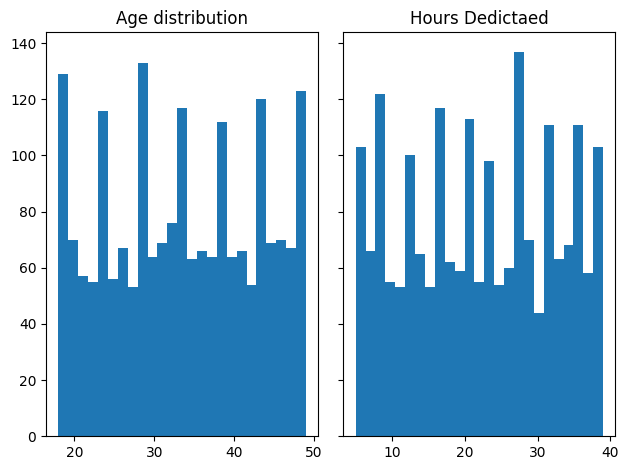

In [ ]:
#plot distribution of features with classes > 35
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
dist1 = df["Age"]
dist2 = df["Hours_Dedicated"]
n_bins = 25
# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(dist1, bins=n_bins)
axs[0].title.set_text("Age distribution")
axs[1].hist(dist2, bins=n_bins)
axs[1].title.set_text("Hours Dedictaed")
plt.show()


Data transformation pipeline

In [ ]:
categorical_features

['Gender',
 'Marital_Status',
 'Internet_Availability',
 'Availability',
 'Language_Proficiency',
 'Continent',
 'Soft_Skills']

In [ ]:
numerical_pipeline = Pipeline(
                steps=[
                       ("scaler",MinMaxScaler())]
            )
cat_pipeline = Pipeline(steps=[("one_hot_encoder",OneHotEncoder()),
                                            ("scaler",MaxAbsScaler())])

preprocessor = ColumnTransformer([("num_pippeline",numerical_pipeline,numerical_features),
                                              ("cat_pipeline",cat_pipeline,categorical_features)])

X = df.drop("Internship_success",axis=1)
y = df["Internship_success"]

input_features = preprocessor.fit_transform(X)

Cross Validation

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
#dictionary of models to be used
models = {"Logistic_Regression":LogisticRegression(),
          "light_gradient_boistingt":lgm.LGBMClassifier(random_state=0,verbose=0),"XGboost":xgb.XGBClassifier(random_state=0),
          "Catboost":CatBoostClassifier(random_state=0,silent=True),"Gradient_boosting":GradientBoostingClassifier(random_state=0)}


skf = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

#Custom cross validation function
def run(models):
    #create empty dic for model and scores
    scores = {}
    for model in models.keys():
        scores[model] = [] #create empty lsit to store model scores at on each fold
    for name,model in models.items():
        print(f"Running -- {name}")
        print("-------------------------")
        for i,(train_index, test_index) in enumerate(skf.split(X, y)):
            xtrain, xvalid = X.iloc[train_index], X.iloc[test_index]
            xtrain = preprocessor.fit_transform(xtrain)
            xvalid = preprocessor.fit_transform(xvalid)
            ytrain, yvalid = y.iloc[train_index], y.iloc[test_index]
            model.fit(xtrain, ytrain)
            #make predictions on validation data
            preds_valid =  model.predict(xvalid)
            f1 = f1_score(yvalid, preds_valid)
            print(f"Fold {i} score : ", f1)
            scores[name].append(f1)
        print(f"{model} -- mean f1_score {np.mean(scores[name])}")
        print()

    #take the mean of scores for every model
    for name, model in models.items():
        scores[name] = np.mean(np.array(scores[name]))
    model_names = scores.keys()
    model_scores = scores.values()
    results = {"Model":model_names,"f1-score":model_scores}
    results = pd.DataFrame.from_dict(results) #create dictionary of model and corresponding mean rmse score
    return results

In [ ]:
validation_results= run(models)

Running -- Logistic_Regression
-------------------------
Fold 0 score :  0.8184818481848185
Fold 1 score :  0.819672131147541
Fold 2 score :  0.8229508196721312
Fold 3 score :  0.8178807947019866
Fold 4 score :  0.8159203980099501
Fold 5 score :  0.8289473684210527
Fold 6 score :  0.7999999999999999
Fold 7 score :  0.8177339901477834
Fold 8 score :  0.8146911519198663
Fold 9 score :  0.816260162601626
LogisticRegression() -- mean f1_score 0.8172538664806757

Running -- light_gradient_boistingt
-------------------------
Fold 0 score :  0.795221843003413
Fold 1 score :  0.7847222222222222
Fold 2 score :  0.7771836007130125
Fold 3 score :  0.7770034843205575
Fold 4 score :  0.7804878048780487
Fold 5 score :  0.7860869565217391
Fold 6 score :  0.7802385008517888
Fold 7 score :  0.7789115646258504
Fold 8 score :  0.7943262411347518
Fold 9 score :  0.7735191637630663
LGBMClassifier(random_state=0, verbose=0) -- mean f1_score 0.7827701382034451

Running -- XGboost
-------------------------
Fo

In [ ]:
validation_results.head()

,Model,f1-score
0,Logistic_Regression,0.817254
1,light_gradient_boistingt,0.782770
2,XGboost,0.763433
3,Catboost,0.804326
4,Gradient_boosting,0.808097


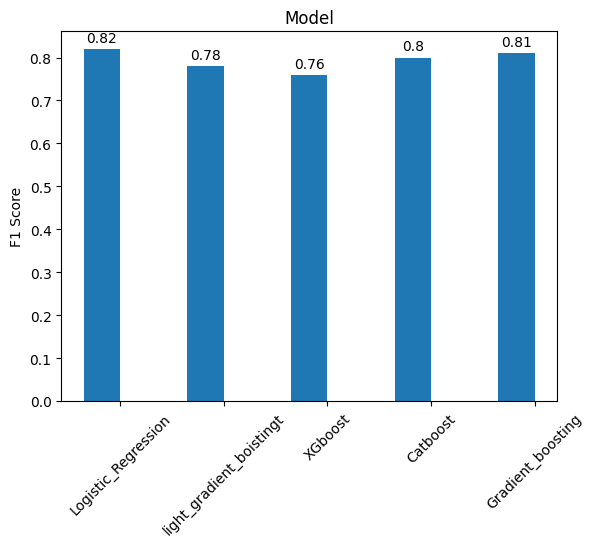

In [ ]:
models  = validation_results["Model"]
score  = np.round(validation_results["f1-score"],2)

x = np.arange(len(models)) # the label locations
width = 0.35 # the width of the bars

fig, ax = plt.subplots()

ax.set_ylabel('F1 Score')
ax.set_title('Model')
ax.set_xticks(x)
ax.set_xticklabels(models,rotation=45)

pps = ax.bar(x - width/2, score, width, label='f1-score')
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 3), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom')

plt.show()

Comment : Logistic regresssion and Gradient boosting machine happens to be the best model so far, we would further perform hyperparameter optimization for better results and analysis

Data splitting

In [ ]:
# Specify the test size and random seed
test_size = 0.2
random_seed = 42

# Split the dataset into a train and test set, maintaining class proportions
X_train, X_test, y_train, y_test = train_test_split(input_features, y, test_size=test_size, stratify=y, random_state=random_seed)


Model Training

- The top two models - Logistic Regression and Gradient boosting classifier

In [ ]:
#Linear Regression
logistic_Reg = LogisticRegression()
logistic_Reg.fit(X_train,y_train)

LogisticRegression()

In [ ]:
#Gradient Boosting classifier
Gradient_boosting = GradientBoostingClassifier()
Gradient_boosting.fit(X_train,y_train)

GradientBoostingClassifier()

Model Evaluation

In [ ]:
#evaluating logistic regression
preds_logR = logistic_Reg.predict(X_test)
print(f"F1-Score for logistic regression is {f1_score(y_test,preds_logR)}")

print("______________________________________________________________________")

#evaluating logistic regression
preds_gradB = Gradient_boosting.predict(X_test)
print(f"F1-Score for Gradient Boosting is {f1_score(y_test,preds_gradB)}")


F1-Score for logistic regression is 0.8243021346469623
___________________________________________________________________
F1-Score for Gradient Boosting is 0.8201680672268907


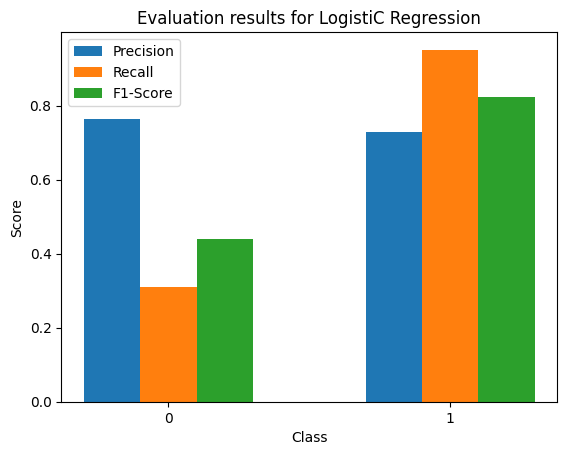

In [ ]:
def class_report(true_labels,predicted_labels,model_name):
      # Compute the classification report
      report = classification_report(true_labels, predicted_labels,output_dict=True)


      # Extract metrics for each class
      precision = [report[str(i)]['precision'] for i in range(2)]
      recall = [report[str(i)]['recall'] for i in range(2)]
      f1_score = [report[str(i)]['f1-score'] for i in range(2)]
      support = [report[str(i)]['support'] for i in range(2)]
      class_names = [str(i) for i in range(2)]

      # Create a bar plot for precision, recall, and F1-score
      x = np.arange(len(class_names))
      width = 0.2

      fig, ax = plt.subplots()
      bar_width = 0.2
      index = np.arange(len(class_names))

      plt.bar(index - bar_width, precision, bar_width, label='Precision')
      plt.bar(index, recall, bar_width, label='Recall')
      plt.bar(index + bar_width, f1_score, bar_width, label='F1-Score')

      plt.xlabel('Class')
      plt.ylabel('Score')
      plt.xticks(index, class_names)
      plt.title(f"Evaluation results for {model_name}")
      plt.legend()
      plt.show()
class_report(true_labels=y_test,predicted_labels=preds_logR,model_name="Logistic Regression")

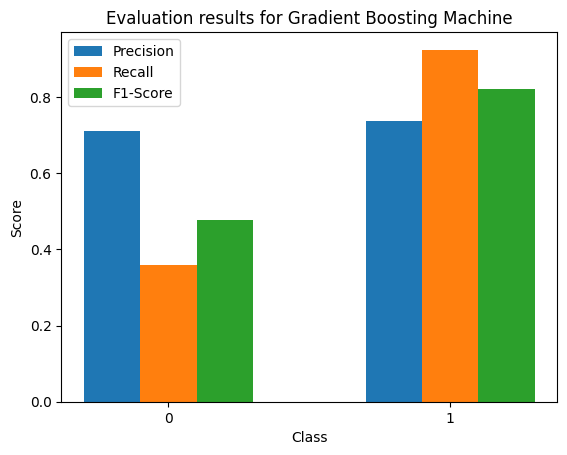

In [ ]:
class_report(true_labels=y_test,predicted_labels=preds_gradB,model_name="Gradient Boosting Machine")

Hyperparameter Optimization
- We will use optuna to optimize gradient boosting and catboost parameters and evaluated the resulted outcome



In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.1 MB/s eta 0:00:00


In [ ]:
# Define an objective function for Optuna
def objective(trial):
    # Load your dataset and split it into training and validation sets
    # X_train, y_train, X_val, y_val = ...

    # Define the hyperparameters to be optimized
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
    }

    # Create and train the CatBoost model
    model = CatBoostClassifier(**params, verbose=0)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)

    # Calculate the accuracy as the metric to optimize
    accuracy = f1_score(y_test, y_pred)

    return accuracy

if __name__ == "__main__":
    # Load your dataset and split it into training and validation sets
    # X_train, y_train, X_val, y_val = ...

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Print the best hyperparameters and their corresponding accuracy
    best_params_catboost = study.best_params
    best_f1_catboost = study.best_value
    print("Best Hyperparameters:", best_params_catboost)
    print("Best f1-score:", best_f1_catboost)

    # Train the final model with the best hyperparameters on the entire training set
    final_model = CatBoostClassifier(**best_params_catboost, verbose=0)
    #final_model.fit(X_train, y_train)


[I 2023-11-09 21:13:16,422] A new study created in memory with name: no-name-0d024ec8-e2f1-4735-8d9e-6f89bc7e2bed
[I 2023-11-09 21:13:17,125] Trial 0 finished with value: 0.8131147540983606 and parameters: {'iterations': 341, 'depth': 6, 'learning_rate': 0.028106056981257243, 'l2_leaf_reg': 0.07175273049721868}. Best is trial 0 with value: 0.8131147540983606.
[I 2023-11-09 21:13:18,314] Trial 1 finished with value: 0.8336079077429984 and parameters: {'iterations': 550, 'depth': 5, 'learning_rate': 0.010894987280137757, 'l2_leaf_reg': 0.2950080589963245}. Best is trial 1 with value: 0.8336079077429984.
[I 2023-11-09 21:13:30,171] Trial 2 finished with value: 0.7999999999999999 and parameters: {'iterations': 894, 'depth': 9, 'learning_rate': 0.047026385131158546, 'l2_leaf_reg': 0.010016645204603707}. Best is trial 1 with value: 0.8336079077429984.
[I 2023-11-09 21:13:31,858] Trial 3 finished with value: 0.8066666666666666 and parameters: {'iterations': 916, 'depth': 4, 'learning_rate': 0

Best Hyperparameters: {'iterations': 527, 'depth': 5, 'learning_rate': 0.01000285893710655, 'l2_leaf_reg': 0.17963640432367475}
Best f1-score: 0.8369028006589787


In [ ]:
# Define an objective function for Optuna
def objective(trial):
    # Load your dataset and split it into training and validation sets
    # X_train, y_train, X_val, y_val = ...

    # Define the hyperparameters to be optimized
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_loguniform('gamma', 1e-5, 1.0),
    }

    # Create and train the XGBoost model
    model = xgb.XGBClassifier(**params, verbosity=0)
    model.fit(X_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(X_test)

    # Calculate the accuracy as the metric to optimize
    f1 = f1_score(y_test, y_pred)

    return f1

if __name__ == "__main__":
    # Load your dataset and split it into training and validation sets
    # X_train, y_train, X_val, y_val = ...

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Print the best hyperparameters and their corresponding accuracy
    best_params_xgb = study.best_params
    best_f1_xgb= study.best_value
    print("Best Hyperparameters:", best_params_xgb)
    print("Best Accuracy:", best_f1_xgb)

    # Train the final model with the best hyperparameters on the entire training set
    final_model = xgb.XGBClassifier(**best_params_xgb, verbosity=0)
    final_model.fit(X_train, y_train)

    # Make predictions on your test set with the final model
    # y_test = final_model.predict(X_test)


[I 2023-11-09 21:16:24,470] A new study created in memory with name: no-name-c68fa0b0-cffa-43a4-8c14-e01a0fa40484
[I 2023-11-09 21:16:24,909] Trial 0 finished with value: 0.8341708542713568 and parameters: {'n_estimators': 485, 'max_depth': 3, 'learning_rate': 0.01102132715996339, 'gamma': 3.909098935899288e-05}. Best is trial 0 with value: 0.8341708542713568.
[I 2023-11-09 21:16:25,179] Trial 1 finished with value: 0.7827586206896552 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.14227225152107528, 'gamma': 0.07966930746252825}. Best is trial 0 with value: 0.8341708542713568.
[I 2023-11-09 21:16:25,679] Trial 2 finished with value: 0.7783595113438045 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.16113273077032106, 'gamma': 0.07620584361774548}. Best is trial 0 with value: 0.8341708542713568.
[I 2023-11-09 21:16:26,253] Trial 3 finished with value: 0.8048359240069085 and parameters: {'n_estimators': 314, 'max_depth': 8, 'learning_rat

Best Hyperparameters: {'n_estimators': 325, 'max_depth': 4, 'learning_rate': 0.014726312925538531, 'gamma': 0.0007729120651621279}
Best Accuracy: 0.8350168350168351


In [ ]:
print(f"F1-score of xgbbost after hyperparameter is {round(best_f1_xgb,3)}")
print()
print(f"F1-score of catboost after hyperparameter is {round(best_f1_catboost,3)}")

F1-score of xgbbost after hyperparameter is 0.835

F1-score of catboost after hyperparameter is 0.837


Comment : Catboost happens to be the best model so far...hurray!!!

Training the best model with the desired parameters

In [ ]:
best_model = CatBoostClassifier(**best_params_catboost, verbose=0)
best_model.fit(X_train,y_train)
preds = best_model.predict(X_test)

print(f"F1-Score is {f1_score(preds,y_test):.2f}")

F1-Score is 0.84


Model Explanability

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
# Fits the explainer
import shap
explainer = shap.Explainer(best_model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

PermutationExplainer explainer: 401it [02:16,  2.74it/s]


In [ ]:
# Evaluate SHAP values
from scipy.special import softmax
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")


In [ ]:
print_feature_importances_shap_values(shap_values,features=X.columns)

Age -> 0.0161 (softmax = 0.0279)
Marital_Status -> 0.0160 (softmax = 0.0279)
Year_of_Study -> 0.0126 (softmax = 0.0278)
Work_Experience -> 0.0101 (softmax = 0.0277)
Non-student -> 0.0083 (softmax = 0.0277)
Internship_Experience -> 0.0070 (softmax = 0.0276)
Soft_Skills -> 0.0044 (softmax = 0.0276)
Hours_Dedicated -> 0.0028 (softmax = 0.0275)
Availability -> 0.0025 (softmax = 0.0275)
Research_Experience -> 0.0023 (softmax = 0.0275)
Internet_Availability -> 0.0022 (softmax = 0.0275)
Language_Proficiency -> 0.0021 (softmax = 0.0275)
Continent -> 0.0016 (softmax = 0.0275)
Gender -> 0.0014 (softmax = 0.0275)
Student -> 0.0013 (softmax = 0.0275)


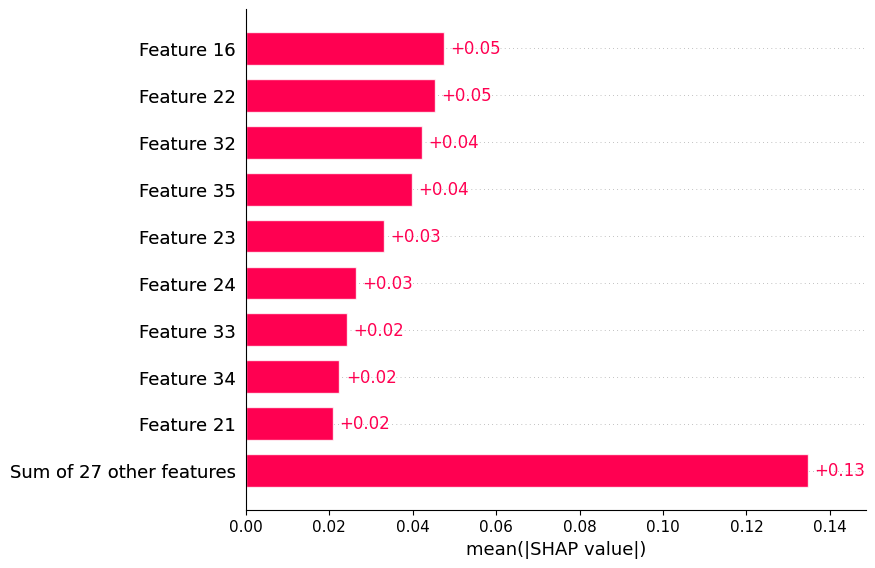

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
!pip